In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
df = pd.read_csv("RELIANCE.NS.csv")

In [4]:
# Drop any missing values
df.dropna(inplace=True)

# Convert the 'Date' column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Select the 'Close' column as the target variable
target_col = 'Close'

# Define the sliding window size
window_size = 30

In [21]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-05-03,397.729919,404.119354,393.717957,0.004132,369.337555,5961256.0
1,2013-05-06,397.333679,408.601868,397.333679,0.008427,379.072693,4318845.0
2,2013-05-07,406.893066,414.025452,405.976746,0.009760,382.094757,7628531.0
3,2013-05-08,411.152679,412.539551,407.165466,0.010065,382.786896,5472648.0
4,2013-05-09,410.310669,411.920410,403.673584,0.007714,377.457886,3776240.0


In [22]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2462,2023-04-25,2366.000000,2380.600098,2350.500000,0.817622,2376.050049,4262471.0
2463,2023-04-26,2379.000000,2386.100098,2354.050049,0.811890,2362.100098,3977129.0
2464,2023-04-27,2375.000000,2384.000000,2364.000000,0.818033,2377.050049,4230627.0
2465,2023-04-28,2382.000000,2423.899902,2381.750000,0.835889,2420.500000,7183342.0
2466,2023-05-02,2436.199951,2445.800049,2428.100098,0.844334,2441.050049,5988299.0


In [5]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df[[target_col]] = scaler.fit_transform(df[[target_col]])

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size].reset_index(drop=True)
test_df = df[train_size:].reset_index(drop=True)

# Create sliding windows of data for the training set
train_X, train_y = [], []
for i in range(window_size, len(train_df)):
    train_X.append(train_df[target_col].iloc[i-window_size:i])
    train_y.append(train_df[target_col].iloc[i])
train_X, train_y = np.array(train_X), np.array(train_y)

# Create sliding windows of data for the testing set
test_X, test_y = [], []
for i in range(window_size, len(test_df)):
    test_X.append(test_df[target_col].iloc[i-window_size:i])
    test_y.append(test_df[target_col].iloc[i])
test_X, test_y = np.array(test_X), np.array(test_y)

In [6]:
# Reshape the data to fit the LSTM input shape
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam

In [8]:
# Define a function to build the LSTM model
def build_lstm(look_back=30, units=32, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [9]:
# Create a KerasRegressor with the build_lstm function
regressor = KerasRegressor(build_fn=build_lstm, verbose=0)

# Define the hyperparameters to test using GridSearchCV
params = {
    'look_back': [30],
    'units': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 50]
}

/var/folders/6h/p8nwbyjj3sv4vz65r6gg_vdm0000gn/T/ipykernel_7342/2423348907.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=build_lstm, verbose=0)


In [10]:
# Create a GridSearchCV object with the KerasRegressor and hyperparameters
grid_search = GridSearchCV(estimator=regressor, param_grid=params, cv=5,error_score='raise')

# Fit the GridSearchCV object to the training data
grid_search.fit(train_X, train_y)

# Print the best hyperparameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

Metal device set to: Apple M2


2023-05-08 00:50:37.807338: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


{'batch_size': 16, 'epochs': 50, 'look_back': 30, 'optimizer': 'adam', 'units': 64}
-9.199438682117034e-05


In [11]:
# Use the best hyperparameters to create the final model
best_params = grid_search.best_params_
model = build_lstm(look_back=best_params['look_back'], units=best_params['units'], optimizer=best_params['optimizer'])

In [12]:
# Train the model on the training data
history = model.fit(train_X, train_y, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2, validation_data=(test_X, test_y))

Epoch 1/50
122/122 - 6s - loss: 0.0040 - val_loss: 0.0013 - 6s/epoch - 50ms/step
Epoch 2/50
122/122 - 1s - loss: 3.7430e-04 - val_loss: 9.8734e-04 - 980ms/epoch - 8ms/step
Epoch 3/50
122/122 - 1s - loss: 3.2274e-04 - val_loss: 0.0018 - 1s/epoch - 9ms/step
Epoch 4/50
122/122 - 1s - loss: 3.0739e-04 - val_loss: 0.0013 - 967ms/epoch - 8ms/step
Epoch 5/50
122/122 - 1s - loss: 2.9173e-04 - val_loss: 0.0010 - 1s/epoch - 11ms/step
Epoch 6/50
122/122 - 1s - loss: 2.6237e-04 - val_loss: 7.0257e-04 - 1s/epoch - 9ms/step
Epoch 7/50
122/122 - 1s - loss: 2.2449e-04 - val_loss: 9.0276e-04 - 1s/epoch - 9ms/step
Epoch 8/50
122/122 - 1s - loss: 2.2803e-04 - val_loss: 7.2859e-04 - 951ms/epoch - 8ms/step
Epoch 9/50
122/122 - 1s - loss: 2.2291e-04 - val_loss: 6.1936e-04 - 914ms/epoch - 7ms/step
Epoch 10/50
122/122 - 1s - loss: 2.1305e-04 - val_loss: 0.0015 - 1s/epoch - 8ms/step
Epoch 11/50
122/122 - 1s - loss: 2.1272e-04 - val_loss: 9.4941e-04 - 950ms/epoch - 8ms/step
Epoch 12/50
122/122 - 1s - loss: 2.01

15/15 [==============================] - 1s 26ms/step


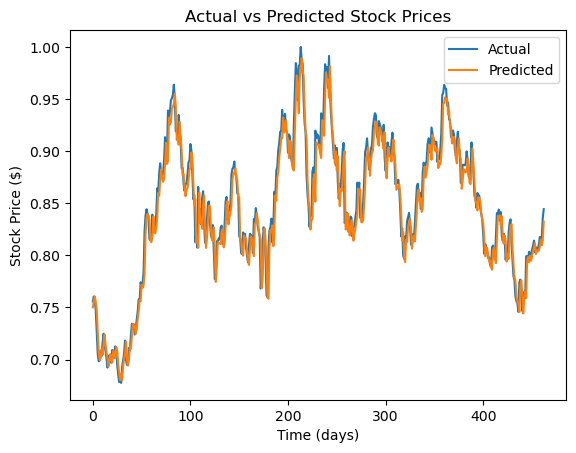

In [13]:
import matplotlib.pyplot as plt

# Make predictions on the testing data with the trained model
y_pred = model.predict(test_X)

# # Inverse transform the normalized data
# y_pred = scaler.inverse_transform(y_pred)
# # Reshape test_y to a 2D array
# test_y_2d = np.reshape(test_y, (-1, 1))

# # Inverse transform the normalized data
# y_pred = scaler.inverse_transform(y_pred)
# test_y = scaler.inverse_transform(test_y_2d)


# Plot the actual and predicted values
plt.plot(test_y, label='Actual')
plt.plot(y_pred, label='Predicted')

plt.xlabel('Time (days)')
plt.ylabel('Stock Price ($)')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [17]:
loss = model.evaluate(test_X, test_y)

# print the loss value
print("Loss: {:.6f}".format(loss))

15/15 [==============================] - 0s 16ms/step - loss: 2.6568e-04
Loss: 0.000266


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assuming y_true and y_pred are the true and predicted labels, respectively
mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.000265680945617299
MAE: 0.01241120369819069
R-squared: 0.9428151398882008
RMSE: 0.01629972225583304
